# Data Exploration & Cleaning Notebook

**Project**: Heart Disease Prediction

**Date**: 2026-01-20

The goals of this analysis are:

1) Perform a thorough analysis of the 

Column Descriptions:

| Var. Name |  Role | Type | Units | Notes |
|------|------|------|-------|-------|
|  Age |  Predictor  |  Int  | years | Age of the patient |
|  Sex |  Predictor  |  Categorical | N/A | Male/Female  |
| Chest Pain | Predictor | Categorical | N/A | Chest pain type |
| Rest BP | Predictor | Integer | mmHg | Resting blood pressure (on admission to the hospital) |
| Chol | Predictor | Integer | mg/dl | Serum cholesterol |
| FBS | Predictor | Categorical | N/A | Fasting blood sugar > 120 mg/dl |
| Rest ECG | Predictor | Categorical | N/A | Resting electrocardiographic results |
| Max HR | Predictor | Integer | bpm | 	Maximum heart rate achieved |
| Ex Angina | Predictor | Categorical | N/A | exercise-induced angina |
| Oldpeak | Predictor | Integer |  mm | ST depression induced by exercise relative to rest |
| Slope | Predictor | Categorical | N/A | The slope of the peak exercise ST segment |
| Ca | Predictor |  Integer | N/A | Number of major vessels (0-3) colored by fluoroscopy |
| Thal | Predictor | Categorical | N/A | normal; fixed defect; reversible defect | 
| CVD Class | Target | Integer | N/A | Diagnosis of heart disease (0-4) |

Additional Information:

Chest Pain Type: 
 typical angina, atypical angina, non-anginal, asymptomatic

Rest ECG: 
normal, stt abnormality, lv hypertrophy

Thal: 
normal; fixed defect; reversible defect

Creators:

Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency


from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [31]:
# Load the datasets
data_path = Path('./data')
files = data_path.glob('*.data')

# Defining the column names 
cols = ["Age", "Sex", "Chest Pain", "Rest BP", "Chol", "FBS", "Rest ECG", "Max HR", "Ex Angina", "Oldpeak", "Slope", "Ca", "Thal", "CVD Class"]

dfs = [pd.read_csv(f, sep=",") for f in files]

# Assign the same column name to each dataframe
for df in dfs:
    df.columns = cols

df = pd.concat(dfs, ignore_index=True)


In [32]:
df.head()

,Age,Sex,Chest Pain,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal,CVD Class
0,29.0,1.0,2.0,120,243,0,0,160,0,0.0,?,?,?,0
1,29.0,1.0,2.0,140,?,0,0,170,0,0.0,?,?,?,0
2,30.0,0.0,1.0,170,237,0,1,170,0,0.0,?,?,6,0
3,31.0,0.0,2.0,100,219,0,1,150,0,0.0,?,?,?,0
4,32.0,0.0,2.0,105,198,0,0,165,0,0.0,?,?,?,0


In [33]:
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")

Dataset shape: (916, 14)
Rows: 916, Columns: 14


In [34]:
# Data types
print("\n=== Data Types ===")
print(df.dtypes.value_counts())
print("\nDetailed data types:")
print(df.dtypes)

# Basic info
print("\n=== Dataset Info ===")
df.info()


=== Data Types ===
object     10
float64     3
int64       1
Name: count, dtype: int64

Detailed data types:
Age           float64
Sex           float64
Chest Pain    float64
Rest BP        object
Chol           object
FBS            object
Rest ECG       object
Max HR         object
Ex Angina      object
Oldpeak        object
Slope          object
Ca             object
Thal           object
CVD Class       int64
dtype: object

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         916 non-null    float64
 1   Sex         916 non-null    float64
 2   Chest Pain  916 non-null    float64
 3   Rest BP     916 non-null    object 
 4   Chol        916 non-null    object 
 5   FBS         916 non-null    object 
 6   Rest ECG    916 non-null    object 
 7   Max HR      916 non-null    object 
 8   Ex Angina   916 non-null  

In [35]:
# Replacing all the question marks with NaN values
df = df.replace("?", np.nan)

missing_data = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

missing_data

,Missing_Count,Missing_Percentage
Ca,608,66.38
Thal,483,52.73
Slope,308,33.62
FBS,89,9.72
Oldpeak,62,6.77
Rest BP,59,6.44
Ex Angina,55,6.00
Max HR,55,6.00
Chol,30,3.28
Rest ECG,2,0.22


Here we face a dillema with the missing values. I'll break them down into two categories: high missingness (>30% missing) and low missingness (<10% missing).

I want to use the best approach possible for dealing with these features. For example, might it be better to perform imputation on the columns that have low missingness (<10% of total rows)? For those that have a significant number of missing values (Ca, Thal, Slope), perhaps performing some kind of unsupervised learning method to approximate the most likely value using other features would make sense? Perhaps simply dropping the features would be sufficient.

When looking at the description of the high missingness features, we see that they are all cardiac stress test results that require specialized equipment or procedures, which explains why a large quantity are missing. Because they are medically significant indicators of cardiac health, simply dropping these predictors will likely not improve the model's performance.

- **ca**: number of major vessels (0-3) colored by flourosopy

- **thal**: 3 = normal; 6 = fixed defect; 7 = reversable defect

- **slope**: the slope of the peak exercise ST segment 
    -- Value 1: upsloping 
    -- Value 2: flat 
    -- Value 3: downsloping

For the other values, using simple imputation is likely to be fine. 

In [36]:
missing_cols = missing_data.index 

# Create binary missingness indicators
missing_matrix = df[missing_cols].isnull().astype(int)
missing_matrix.columns = [f"{col}_missing" for col in missing_cols]

# Calculate co-occurrence (correlation of missingness)
cooccurrence = missing_matrix.corr()

cooccurrence.head(3).round(2)

,Ca_missing,Thal_missing,Slope_missing,FBS_missing,Oldpeak_missing,Rest BP_missing,Ex Angina_missing,Max HR_missing,Chol_missing,Rest ECG_missing
Ca_missing,1.00,0.71,0.49,0.19,0.19,0.19,0.18,0.18,0.12,0.03
Thal_missing,0.71,1.00,0.45,0.10,0.19,0.21,0.22,0.22,0.15,0.04
Slope_missing,0.49,0.45,1.00,-0.07,0.38,0.34,0.35,0.35,0.15,0.02


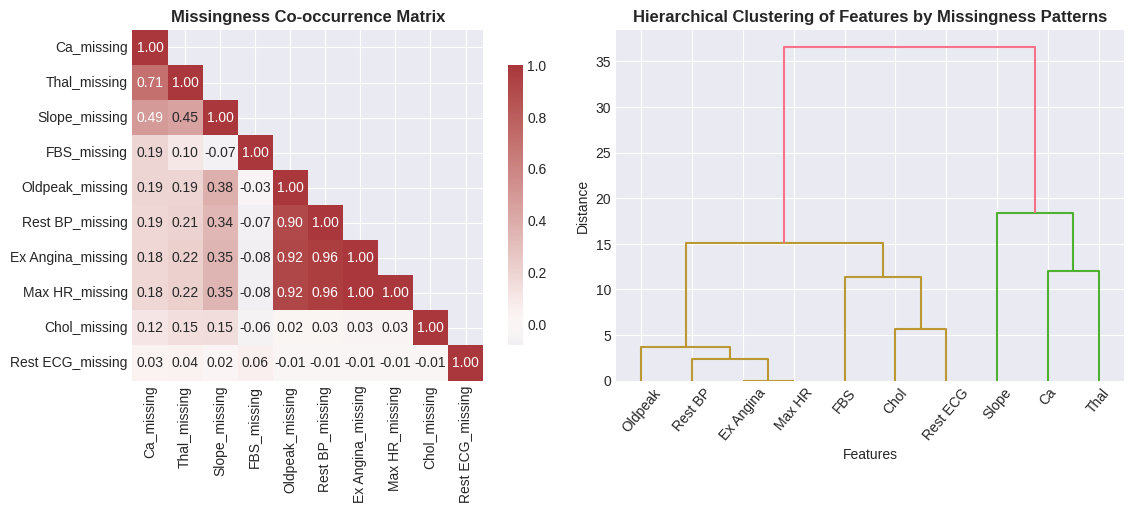

In [ ]:
# Plotting the correlation of missing features
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
mask = np.triu(np.ones_like(cooccurrence, dtype=bool), k=1)
sns.heatmap(cooccurrence, annot=True, fmt='.2f', cmap='vlag',
            center=0, square=True, mask=mask, cbar_kws={"shrink": 0.8}, ax=ax[0])
ax[0].set_title('Missingness Co-occurrence Matrix', 
         fontweight='bold')


# Cluster features by missingness patterns
linkage_matrix = linkage(missing_matrix.T, method='ward')

dendrogram(linkage_matrix, labels=[col.replace('_missing', '') 
                                    for col in missing_matrix.columns],
           leaf_rotation=50, leaf_font_size=10, ax=ax[1])
ax[1].set_title('Hierarchical Clustering of Features by Missingness Patterns', fontweight='bold')
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Distance')


plt.tight_layout()
plt.show()

Looking at the results from this analysis, it is clear that the patterns in missingness are not a coincidence. The dendogram and correlation matrix confirm that Slope, Ca, and Thal have a high co-occurence rate and are clustered together. Nonetheless, other features that have lower missing incidence seem to have even greater correlation and smaller distances from each other than the features that are missing a significant amount of values.

This may indicate that certain regions perform these tests together, and others may forgo them entirely. It's a nice proxy visualization for the four different datasets that are merged together, indicating the population differences that exist between them.

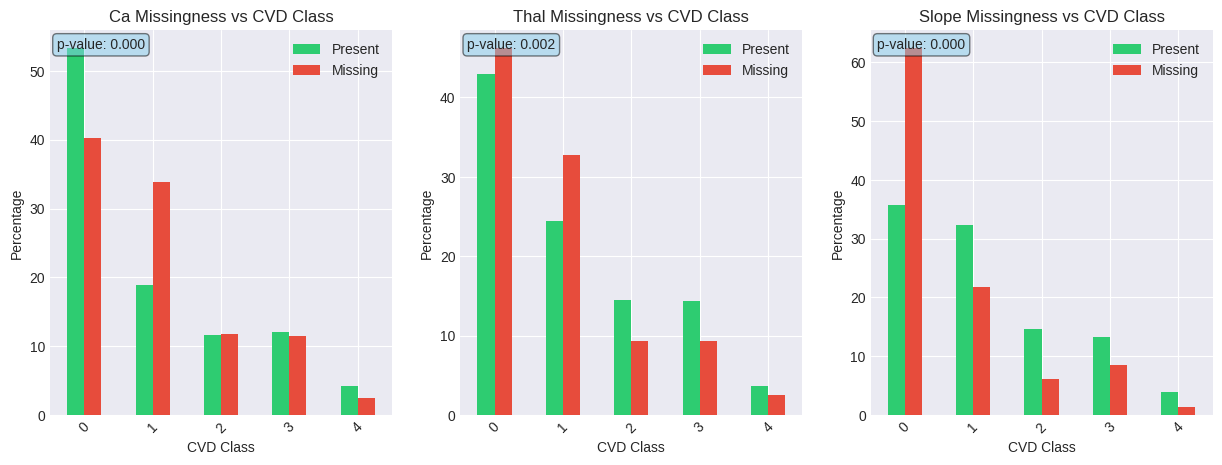

In [46]:
# 
high_miss_features = ['Ca', 'Thal', 'Slope']
target_col = 'CVD Class'

# Create visualization
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for idx, feature in enumerate(high_miss_features):
    if idx < len(high_miss_features):
        is_missing = df[feature].isnull()
        cross_tab = pd.crosstab(df[target_col], is_missing, normalize='columns') * 100
        
        cross_tab.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(f'{feature} Missingness vs {target_col}')
        axes[idx].set_xlabel(target_col)
        axes[idx].set_ylabel('Percentage')
        axes[idx].legend(['Present', 'Missing'], loc='best')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
        
        # Chi-square test
        contingency = pd.crosstab(df[target_col], is_missing)
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        axes[idx].text(0.02, 0.98, f'p-value: {p_value:.3f}', 
                        transform=axes[idx].transAxes, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.5))

The results above suggest that the individuals who have missing values and those who have the values present across the top three missing predictors (Ca, Thal, Slope), come from a different population. This makes sense as the dataset is composed of individuals from different regions of the world (United States, Hungary, Switzerland) which may have very different lifestyles and diets, along with wealth (which may explain why )

As a result of this analysis we can confidently say there is a pattern that exists within the missing data, and therefore it is *Missing Not At Random (MNAR)*.

## Implications

- Missingness is structured by data source (different hospitals/regions).
- The populations are fundamentally different (lifestyle, diet, wealth, healtcare system).
- Missing tests likely reflect different diagnostic protocols rather than random omission.

In [ ]:
# Adding binary flags to the high missingness columns
for missing_col in high_miss_features:
    df[missing_col].isnull().astype(int)


In [49]:
# Numeric columns
numeric_cols = df.select_dtypes(include="number").columns.tolist()

df[numeric_cols].describe().round(2)

,Age,Sex,Chest Pain,CVD Class
count,916.00,916.00,916.00,916.00
mean,53.54,0.79,3.26,1.00
std,9.37,0.41,0.93,1.14
min,29.00,0.00,1.00,0.00
25%,47.00,1.00,3.00,0.00
50%,54.00,1.00,4.00,1.00
75%,60.00,1.00,4.00,2.00
max,77.00,1.00,4.00,4.00


In [ ]:
# Categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

unique_count = df[categorical_cols].nunique()

unique_count


Rest BP      102
Chol         334
FBS            4
Rest ECG       6
Max HR       197
Ex Angina      4
Oldpeak       81
Slope          6
Ca             7
Thal           6
dtype: int64